In [1]:
import time

import tensorflow as tf
import numpy as np

import skimage
import skimage.io
import skimage.transform
import matplotlib.pyplot as plt
import custom_vgg19
import Lib

In [2]:
BATCH_SIZE = 10
input_shape = [BATCH_SIZE, 256, 256, 3]
STYLE_LAYERS = ('conv1_1', 'conv2_1', 'conv3_1', 'conv4_1')
CONTENT_LAYER = 'conv4_2' # I can get good result with relu3_2 with slow neural-style with same weight. maybe I can try here
CONTENT_WEIGHT = 7.5
STYLE_WEIGHT = 100
NEW_H, NEW_W = 256, 256

In [5]:
styleimg = Lib.load_image_as_batch_with_optional_resize('./picasso_selfport1907.jpg')
print(styleimg.shape)
contentimg = Lib.load_image_as_batch_with_optional_resize('./brad_pitt.jpg', newH=NEW_H, newW=NEW_W)
print(contentimg.shape)

# show image
# skimage.io.imshow(contentimg[0])
# plt.show()

(1, 600, 468, 3)
(1, 256, 256, 3)


In [7]:
# Now we can go ahead and extract content features and style features
sess=tf.Session()
styleimg_ph = tf.placeholder(tf.float32, shape=styleimg.shape)
vgg19factory = custom_vgg19.Vgg19Factory()
vgg19_pretrain = vgg19factory.build(styleimg_ph)

# sanity check: make sure the layer names are correct
try:
    style_layers_pretrain = [getattr(vgg19_pretrain, name) for name in STYLE_LAYERS]
    content_layer_pretrain = getattr(vgg19_pretrain, CONTENT_LAYER)
except Exception as ex:
    print ex,  "incorrect layer name. Note: all layer named 'conv' is relu. e.g. 'conv1_1' is actually 'relu1_1'"
    sys.exit(1)

styleimg_grams = [gram_matrix(l) for l in style_layers_pretrain]
styleimg_grams_np = sess.run(styleimg_grams, feed_dict={styleimg_ph:styleimg})
# contentimg_feat_map_np = sess.run(content_layer_pretrain, feed_dict={styleimg_ph:contentimg}) # just for debug propose. It's not slow neural-style, so there is no target content img during training
styleimg_grams = [tf.constant(g, dtype=tf.float32) for g in styleimg_grams_np]

/work/04006/zhuode93/maverick/dlproj2/trainable-neural-style/tensorflow_vgg/vgg19.npy
npy file loaded


In [8]:
# construct img transfrom network
img_train = tf.placeholder(tf.float32, input_shape)
img_pred = Lib.buildTransformNet(img_train, expected_shape=input_shape)

conv layer, output size: [10, 256, 256, 32]
conv layer, output size: [10, 128, 128, 64]
conv layer, output size: [10, 64, 64, 128]
START residual_block 
conv layer, output size: [10, 64, 64, 128]
conv layer, output size: [10, 64, 64, 128]
END residual_block
START residual_block 
conv layer, output size: [10, 64, 64, 128]
conv layer, output size: [10, 64, 64, 128]
END residual_block
START residual_block 
conv layer, output size: [10, 64, 64, 128]
conv layer, output size: [10, 64, 64, 128]
END residual_block
START residual_block 
conv layer, output size: [10, 64, 64, 128]
conv layer, output size: [10, 64, 64, 128]
END residual_block
START residual_block 
conv layer, output size: [10, 64, 64, 128]
conv layer, output size: [10, 64, 64, 128]
END residual_block
deconv layer, output size: [10, 128, 128, 64]
deconv layer, output size: [10, 256, 256, 32]
conv layer, output size: [10, 256, 256, 3]


In [9]:
# construct vgg19 to extract pred img's content & style
vgg19_pred = vgg19factory.build(img_pred)  # make sure pred img have VGG19's desired scale and range([0,1])
style_layers_pred = [getattr(vgg19_pred, name) for name in STYLE_LAYERS]
content_layer_pred = getattr(vgg19_pred, CONTENT_LAYER)

# construct vgg19 to extract train img's content as ground truth
vgg19_extractContent = vgg19factory.build(img_train)    # TODO ugly solution! 
   # So, in total I have to build 3 same vgg19 just because I have different input Tensor 
    # (two are placeholders of different shapes; the other one is the predicted image). Any way to avoid this?
content_layer_target = getattr(vgg19_extractContent, CONTENT_LAYER)


In [10]:
style_losses = [Lib.compute_style_loss(styleimg_grams[i], style_layers_pred[i]) for i in xrange(len(styleimg_grams))]
content_loss = Lib.compute_content_loss(content_layer_target, content_layer_pred)
loss = STYLE_WEIGHT * reduce(tf.add, style_losses) + CONTENT_WEIGHT * content_loss
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_op = optimizer.minimize(loss)

** integration test: read some pictures and overfit the network to it **

In [11]:
import os
test_batch_f = filter(lambda s:s.startswith('COCO'), os.listdir('data'))[:BATCH_SIZE]
assert len(test_batch_f) == BATCH_SIZE, ('not enough files', len(test_batch_f))
test_batch_np = np.zeros(input_shape)
for i in xrange(BATCH_SIZE):
    test_batch_np[i] = load_image_as_batch_with_optional_resize('data/'+test_batch_f[i], newH=NEW_H, newW=NEW_W)

sess.run(tf.initialize_all_variables())

In [36]:
MAX_ITER = 200
for i in xrange(MAX_ITER):
    l = sess.run([train_op, loss]+ style_losses +[content_loss], feed_dict={img_train: test_batch_np})
    print l[1:]

[360445.06, 162.21439, 844.54523, 73.654099, 588.52539, 25806.818]
[360798.66, 161.84303, 845.63446, 74.175003, 587.11682, 25856.23]
[360988.19, 162.04202, 848.34375, 74.008278, 582.90546, 25901.096]
[361519.25, 162.08023, 842.75146, 72.835526, 617.6947, 25597.74]
[363431.16, 162.23441, 849.42316, 75.775543, 568.70111, 26375.697]
[367559.25, 161.91458, 845.91473, 73.196373, 706.74176, 25171.0]
[371064.38, 163.3268, 854.85791, 75.770439, 584.63715, 27094.021]
[368430.44, 161.92172, 844.95227, 74.753181, 699.39081, 25377.148]
[363820.06, 162.82242, 849.04657, 72.965027, 588.47589, 26198.543]
[363423.12, 162.04637, 849.34296, 76.00753, 579.34143, 26233.238]
[366442.31, 162.22321, 844.74573, 73.62574, 674.98944, 25451.184]
[363630.12, 163.19931, 848.8584, 73.770081, 580.9519, 26260.285]
[363673.06, 161.58076, 851.04901, 75.510895, 587.69592, 26145.254]
[364230.88, 162.44168, 843.9696, 72.795158, 634.80725, 25710.602]
[362633.78, 162.88399, 845.11542, 73.947205, 599.42249, 25932.916]
[36340

In [1]:
img_pred_np = sess.run(img_pred, feed_dict={img_train: test_batch_np})

f,axarr=plt.subplots(3,3, figsize=(10,10))
for i in xrange(3):  
    for j in xrange(3):
        img = np.clip(img_pred_np[i*3+j],0,1)
        axarr[i][j].imshow(img)
        axarr[i][j].xaxis.set_visible(False)
        axarr[i][j].yaxis.set_visible(False)
plt.show()

NameError: name 'sess' is not defined

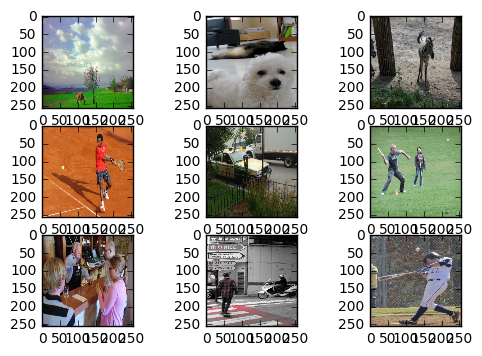

In [21]:
f,axarr=plt.subplots(3,3)
for i in xrange(3): 
    for j in xrange(3): 
        axarr[i][j].imshow(test_batch_np[i*3+j])
        plt.imsave(str(i*3+j)+)
plt.show()

In [23]:
saver=tf.train.Saver()
saver.save(sess, 'chkpt/cur.ckpt')

'chkpt/cur.ckpt'